In [1]:
import numpy as np
import pandas as pd
from pcse.db import NASAPowerWeatherDataProvider
from pcse.util import reference_ET
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

sys.path.append("../src/")
from sarra_py import *


In [2]:
# https://towardsdatascience.com/read-era5-directly-into-memory-with-python-511a2740bba0
# cdsapi

In [3]:
grid_width = 1
grid_height = 1
duration = 365

In [4]:
from logging import exception


paramVariete = {

                # paramètres depuis Ag3 USA Hars v42_12_ p4 irr
                # # récupérés depuis HV42 parameters
                #variete mais iowa USA V42
                
                "SDJLevee":90, # OK
                "SDJBVP":320, # OK
                "SDJRPR":500, # OK
                "SDJMatu1":560, # OK
                "SDJMatu2":200, # OK
                
                "KRdtPotA": 0.8,  # OK
                "KRdtPotB": 200, # OK

                "PPExp" : 0, # OK
                "SeuilPP" : 13.6, # OK
                "PPsens" : 5, # OK
                "PPCrit": 11, # OK

                "TBase":8, # OK
                "TOpt1":26, # OK
                "TOpt2":34, # OK
                "TLim":44, # OK

                "pcReallocFeuille":0.7, # OK # partFeuilleTige
                'txConversion':5.8, # OK
                'txAssimBVP':1, # OK
                'txAssimMatu1':0.9, # OK
                'txAssimMatu2':0.1,  # OK

                "kRespMaint":0.01, # OK
                "aeroTotBase":0.6, # OK
                "aeroTotPente":5E-5, # OK
                "feuilAeroBase":0.55, # OK
                "feuilAeroPente":-5E-5, # OK

                "txRealloc":0.4, # OK #realloc
                "tempMaint":25, # OK
                "KRdtBiom":0, # OK
                
                "kcMax":1.25, # OK
                # "txRuSurfGermi":0.8,
                "PFactor":0.45, # OK
                "seuilCstrMortality":3, # OK

                'kdf': 0.4,  # OK
                "poidsSecGrain":0.38, # OK
                "txResGrain":0.55, # OK

                "VRacLevee":30.0, # OK
                "VRacBVP":15.0, # OK
                "VRacPSP":15.0, # OK
                "VRacRPR":15.0, # OK
                "VRacMatu1":12.0, # OK
                "VRacMatu2":12.0, # OK

                "slaMin":0.0016, # OK
                "slaMax":0.005, # OK
                "slaPente":0.4, # OK

                "phaseDevVeg":0, # OK
                "senCO2":10, # OK
                
                "densOpti":85000, # OK
                "densiteA":0.7, # OK
                "densiteP":4.5, # OK

                "NIYo":1,
                "NIp":0,
                "LGauss":1,
                "AGauss":1,

                #pas dans les params sarra-h
                # "kTempMaint":25, #remplacé par tempmaint
                # "slaBVP":0.003, #remplacé par slamin
                # "slaRPR":0.003, #remplacé par slamax
                # "KpenteSla":1, #remplacé par slaPente
                # "kBaseLaiDev":0.2, #remplacé par feuilAeroBase
                # "kPenteLaiDev":0.5, # remplacé par feuilAeroPente
                }

if paramVariete["feuilAeroBase"] == 0.1 :
    raise exception()



paramITK = {
            "DateSemis":datetime.date(2012,4,28), # OK
            "profRacIni":0,# OK
            "densite":86500, # OK
            "mulch":100,  # OK
            "seuilEauSemis":0, # OK
            "nbjTestSemis":0, # OK
            "irrigAuto":False, # OK
            "irrigAutoTarget":0, # OK
            "maxIrrig":0, # OK
            "precision":0, # OK
            "biomIniMc":0, # OK
            "humSatMc":0, # OK
            "surfMc":0, # OK
            "coefMc":0, # OK

            "KNUp":0, # OK
            "KNLit":0, # OK
            "KT":0, # OK
            "KI":0, # OK
            
            # non utilisés dans le modèle python
            "DisMc":000000, # OK
            "TxRecolte":0, # OK
            "TxaTerre":0, # OK
            "NbUBT":10, # OK
            
            # non présents dans sarra-h
            "dateFin":300,
            "NI":np.nan, 

            
            
            }

paramTypeSol = {
                "stockIniSurf":30, # OK
                "stockIniProf":170, # OK
                "epaisseurSurf": 200, # OK
                "epaisseurProf" : 1300, # OK

                # params type sol
                "seuilRuiss":20, # OK
                "pourcRuiss":30/100, # OK
                "ru":132, # OK

                # non utilisés mais présents dans sarra-h
                "HumCR":0.32, # OK
                "HumPF":0.18, # OK
                'HumFC':0.32, # OK
                "HumSat":0.48, # OK
                "Pevap":0.2, # OK
                "PercolationMax":5, # OK

                }

if ~np.isnan(paramITK["NI"]):
    print("NI NON NULL") 
    paramVariete["txConversion"] = paramVariete["NIYo"] + paramVariete["NIp"] * (1-np.exp(-paramVariete["NIp"] * paramITK["NI"])) - (np.exp(-0.5*((paramITK["NI"] - paramVariete["LGauss"])/paramVariete["AGauss"])* (paramITK["NI"]- paramVariete["LGauss"])/paramVariete["AGauss"]))/(paramVariete["AGauss"]*2.506628274631)


# ruRac = paramTypeSol["ru"] * paramITK["profRacIni"] / 1000 # alt name rRac
# ruSurf = paramTypeSol["epaisseurSurf"] / 1000 * paramTypeSol["ru"]

In [5]:
lat,long = 42.02, -93.75
date_start = datetime.date(2012,4,1)
duration = 250
 
 # getting weather data
weatherdata = NASAPowerWeatherDataProvider(longitude=long, latitude=lat)
print(weatherdata)
df_weather = pd.DataFrame(weatherdata.export())
df_weather = df_weather[(df_weather["DAY"]>=date_start) & (df_weather["DAY"]<=date_start+datetime.timedelta(days=duration-1))].reset_index(drop=True)
df_weather.head()

df_weather["DOY"] = df_weather.apply(lambda x: x["DAY"].timetuple().tm_yday, axis=1)
df_weather["ET0"] = df_weather["ET0"] * 10 #conversion cm to mm

df_weather["RAIN"] = df_weather["RAIN"] * 10 #conversion cm to mm

Weather data provided by: NASAPowerWeatherDataProvider
--------Description---------
NASA/POWER CERES/MERRA2 Native Resolution Daily Data
----Site characteristics----
Elevation:  310.2
Latitude:  42.020
Longitude: -93.750
Data available for 1984-01-01 - 2022-07-27
Number of missing days: 2



In [6]:
# alt with loading exported data from sarra-h

#lat,long = 42.02, -93.75
elevation = 329

df_weather = pd.read_csv("../data/Meteorologie_US0001.txt", sep="\t", decimal=",", skiprows=1)
df_rain = pd.read_csv("../data/Pluviometrie_US0001.txt", sep="\t", decimal=",", skiprows=1)
df_weather = df_weather.merge(df_rain, right_on=["Jour", "CodeStation"], left_on=["Jour", "CodeStation"])
df_weather["Jour"] = df_weather.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)
df_weather = df_weather[(df_weather["Jour"]>=date_start) & (df_weather["Jour"]<=date_start+datetime.timedelta(days=duration-1))].reset_index(drop=True)

df_weather = df_weather.rename(columns={"Pluie":"RAIN"})

In [7]:
"""def _estimate_AngstAB(self, df_power):
        Determine Angstrom A/B parameters from Top-of-Atmosphere (ALLSKY_TOA_SW_DWN) and
        top-of-Canopy (ALLSKY_SFC_SW_DWN) radiation values.
        :param df_power: dataframe with POWER data
        :return: tuple of Angstrom A/B values
        The Angstrom A/B parameters are determined by dividing swv_dwn by toa_dwn
        and taking the 0.05 percentile for Angstrom A and the 0.98 percentile for
        Angstrom A+B: toa_dwn*(A+B) approaches the upper envelope while
        toa_dwn*A approaches the lower envelope of the records of swv_dwn
        values.
        """

'def _estimate_AngstAB(self, df_power):\n        Determine Angstrom A/B parameters from Top-of-Atmosphere (ALLSKY_TOA_SW_DWN) and\n        top-of-Canopy (ALLSKY_SFC_SW_DWN) radiation values.\n        :param df_power: dataframe with POWER data\n        :return: tuple of Angstrom A/B values\n        The Angstrom A/B parameters are determined by dividing swv_dwn by toa_dwn\n        and taking the 0.05 percentile for Angstrom A and the 0.98 percentile for\n        Angstrom A+B: toa_dwn*(A+B) approaches the upper envelope while\n        toa_dwn*A approaches the lower envelope of the records of swv_dwn\n        values.\n        '

In [8]:
a, b = 17.625, 243.04
df_weather["TMoy"] = ((df_weather["TMin"]+df_weather["TMax"])/2) # + 273.15
# calcul du point de rosée d'après https://www.omnicalculator.com/physics/dew-point
df_weather["PointRosee"] = (b * np.log(df_weather["HMoy"]/100) + a*df_weather["TMoy"]/(b+df_weather["TMoy"])) / (a - np.log(df_weather["HMoy"]/100) + a*df_weather["TMoy"]/(b+df_weather["TMoy"]))
# alternative https://iridl.ldeo.columbia.edu/dochelp/QA/Basic/dewpoint.html
df_weather["PointRosee2"] = df_weather["TMoy"] - ((100 - df_weather["HMoy"])/5)

# calcul de la pression de vapeur d'après https://www.weather.gov/media/epz/wxcalc/vaporPressure.pdf
# rh = e/es * 100
# e = rh/100 * es
df_weather["VapourPressure"] = df_weather["HMoy"]/100 * 6.11 * 10**(7.5*df_weather["TMoy"]/(237.3+df_weather["TMoy"]))
df_weather["VapourPressure2"] = 6.11 * 10**((7.5*df_weather["PointRosee"])/(237.3+df_weather["PointRosee"]))
df_weather["VapourPressure3"] = 6.11 * 10**((7.5*df_weather["PointRosee2"])/(237.3+df_weather["PointRosee2"]))

In [9]:
# angstA et B d'après nasa power
angstA = 0.29
angstB = 0.49
df_weather["ET0"] = df_weather.apply(lambda x: reference_ET(x["Jour"], lat, elevation, x["TMin"] , x["TMax"], x["Rg"]*1E6, x["VapourPressure"], x["Vt"], angstA, angstB, ETMODEL="PM")[2], axis=1)

In [10]:
df_weather = df_weather.rename(columns={"TMoy":"TEMP", "Pluie":"RAIN", 'Rg':'IRRAD'})

In [11]:
df_weather

,CodeStation,Jour,TMax,TMin,TEMP,HMax,HMin,HMoy,Vt,Ins,IRRAD,ETP,RAIN,PointRosee,PointRosee2,VapourPressure,VapourPressure2,VapourPressure3,ET0
0,US0001,2012-04-01,28.6,8.0,18.30,NaN,NaN,79.2,2.8,NaN,20.0,NaN,0.0,-2.903846,14.14,16.662426,4.933175,16.136592,4.059221
1,US0001,2012-04-02,29.4,11.4,20.40,NaN,NaN,73.8,4.3,NaN,19.0,NaN,0.0,-3.756342,15.16,17.693396,4.628181,17.234932,4.722696
2,US0001,2012-04-03,19.3,11.8,15.55,NaN,NaN,73.0,6.0,NaN,18.0,NaN,0.0,-3.969955,10.15,12.900481,4.554427,12.407352,3.498438
3,US0001,2012-04-04,19.6,11.6,15.60,NaN,NaN,46.7,4.4,NaN,16.0,NaN,0.0,-9.460091,4.94,8.279260,2.982877,8.689378,4.630221
4,US0001,2012-04-05,17.3,5.7,11.50,NaN,NaN,37.8,3.6,NaN,21.6,NaN,0.0,-12.150461,-0.94,5.130941,2.405996,5.704451,4.519739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,US0001,2012-12-02,12.8,2.0,7.40,NaN,NaN,89.5,2.5,NaN,7.1,NaN,0.0,-1.448236,5.30,9.218762,5.495255,8.910276,0.705198
246,US0001,2012-12-03,19.6,1.9,10.75,NaN,NaN,86.4,4.8,NaN,4.4,NaN,0.0,-1.878288,8.03,11.158099,5.323573,10.752932,1.697447
247,US0001,2012-12-04,13.2,-2.8,5.20,NaN,NaN,60.0,3.4,NaN,8.5,NaN,0.0,-6.689095,-2.80,5.309055,3.702511,4.971517,1.783130
248,US0001,2012-12-05,5.8,-5.7,0.05,NaN,NaN,60.2,4.5,NaN,5.6,NaN,0.0,-6.800717,-7.91,3.691626,3.670786,3.368376,1.465478


In [12]:
df_ET0 = pd.read_csv("../data/ET0_US0001.txt", sep="\t", decimal=",", skiprows=1)
df_ET0["Jour"] = df_ET0.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)
df_ET0 = df_ET0[(df_ET0["Jour"]>=date_start) & (df_ET0["Jour"]<=date_start+datetime.timedelta(days=duration-1))].reset_index(drop=True)


In [13]:
df_weather = df_weather.merge(df_ET0[["Jour","Eto"]], left_on="Jour", right_on="Jour", how="outer")


In [14]:
df_weather["ET0"] = df_weather["Eto"]
df_weather

,CodeStation,Jour,TMax,TMin,TEMP,HMax,HMin,HMoy,Vt,Ins,IRRAD,ETP,RAIN,PointRosee,PointRosee2,VapourPressure,VapourPressure2,VapourPressure3,ET0,Eto
0,US0001,2012-04-01,28.6,8.0,18.30,NaN,NaN,79.2,2.8,NaN,20.0,NaN,0.0,-2.903846,14.14,16.662426,4.933175,16.136592,3.179907,3.179907
1,US0001,2012-04-02,29.4,11.4,20.40,NaN,NaN,73.8,4.3,NaN,19.0,NaN,0.0,-3.756342,15.16,17.693396,4.628181,17.234932,3.950088,3.950088
2,US0001,2012-04-03,19.3,11.8,15.55,NaN,NaN,73.0,6.0,NaN,18.0,NaN,0.0,-3.969955,10.15,12.900481,4.554427,12.407352,3.642551,3.642551
3,US0001,2012-04-04,19.6,11.6,15.60,NaN,NaN,46.7,4.4,NaN,16.0,NaN,0.0,-9.460091,4.94,8.279260,2.982877,8.689378,4.539865,4.539865
4,US0001,2012-04-05,17.3,5.7,11.50,NaN,NaN,37.8,3.6,NaN,21.6,NaN,0.0,-12.150461,-0.94,5.130941,2.405996,5.704451,4.661987,4.661987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,US0001,2012-12-02,12.8,2.0,7.40,NaN,NaN,89.5,2.5,NaN,7.1,NaN,0.0,-1.448236,5.30,9.218762,5.495255,8.910276,0.508754,0.508754
246,US0001,2012-12-03,19.6,1.9,10.75,NaN,NaN,86.4,4.8,NaN,4.4,NaN,0.0,-1.878288,8.03,11.158099,5.323573,10.752932,0.860828,0.860828
247,US0001,2012-12-04,13.2,-2.8,5.20,NaN,NaN,60.0,3.4,NaN,8.5,NaN,0.0,-6.689095,-2.80,5.309055,3.702511,4.971517,1.791876,1.791876
248,US0001,2012-12-05,5.8,-5.7,0.05,NaN,NaN,60.2,4.5,NaN,5.6,NaN,0.0,-6.800717,-7.91,3.691626,3.670786,3.368376,1.496762,1.496762


In [15]:
df_irrig = pd.read_csv("../data/Irrigation_AG3US20124.txt", sep="\t", decimal=",", skiprows=1)
df_irrig["Jour"] = df_irrig.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)
df_weather = df_weather.merge(df_irrig[["Jour","Irrigation"]], left_on="Jour", right_on="Jour", how="outer")
df_weather.loc[np.isnan(df_weather["Irrigation"]), "Irrigation"] = 0

ordre des modules depuis SarrahV42.docx

In [16]:
def EvalPar(data):
    #depuis meteo.par
    kpar = 0.5
    data["par"] = kpar * data["rg"]
    return data

# Run

In [17]:
data = {}

data = InitPlotMc(data, grid_width, grid_height, paramITK, paramTypeSol, duration) # **** bileau *** # trad OK

data = InitiationCulture(data, grid_width, grid_height, duration, paramVariete)
data = InitSup(data, grid_width, grid_height, duration, df_weather, paramTypeSol, paramITK)
data = EvalPar(data)


for j in range(duration):
    # on reporte en commentaire les fichiers source dans lesquelles se trouvent
    # les procédures concernées. no note ***entre étoiles*** les procédures
    # retenues pour cette traduction python

    
    
    print("\n cycle",j)

    if date_start + datetime.timedelta(days=j) >= paramITK["DateSemis"]:

        data = EvalPhenoSarrahV3(j, data, paramITK, paramVariete) # ***phenologie*** et exmodules ### trad OK
        data = EvalDegresJourSarrahV3(j, data, paramVariete) # ***phenologie*** et exmodules ### trad OK

    print(date_start + datetime.timedelta(days=j))
    #bilan hydrique
    data = EvalIrrigPhase(j, data, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data = PluieIrrig(j, data) # ***bileau***, exmodules 2 ###trad OK
    data = RempliMc(j, data, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data = EvalRunOff(j, data, paramTypeSol) # ***bileau***, exmodules 1 & 2 ###trad OK
    data = EvolRurCstr2(j, data, paramITK) # ***bileau*** ##trad OK
    data = rempliRes(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas ###trad OK
    data = EvalFESW(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad O
    data = EvalKceMc(j, data, paramITK) # ***bileau***, exmodules 2 ###trad OK
    data = DemandeSol(j, data) # ***bileau***, exmodules 1 & 2 ### trad OK
    data = EvapMc(j, data, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data = EvapRuSurf(j, data) # ***bileau***, exmodules 1 & 2 ###trad OK
    data = EvalFTSW(j, data) # ***bileau***, exmodules 1 & 2, risocas, riz ###trad OK
    data = EvolKcpKcIni(j, data, paramVariete) # biomasse, exmodules 1 & 2 # comparaison  code nécessaire pour choix ###trad OK
    data = DemandePlante(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad OK
    data = EvalKcTot(j, data) # ***bileau***, exmodules 1 & 2 ## trad O
    data = CstrPFactor(j, data, paramVariete) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas #trad OK
    data = EvalTranspi(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2 # trad OK
    data = ConsoResSep(j, data) # ***bileau***; exmodules 1 & 2 # trad O
    # phenologie
    data = EvalVitesseRacSarraV3(j, data, paramVariete) # ***phenologie*** , exmodules 1 & 2 # trad OK
    
    # bilan carbone
    data = EvalLtr(j, data, paramVariete) #biomasse, exmodules 1 & 2 # comparaison code nécessaire pour choix #trad OK
    data = EvalConversion(j, data, paramVariete) # mimlbilancarbone copie, ecopalm2_2, exmodules 1 & 2, ***milbilancarbone***, risocas, riz # trad OK
    data = BiomDensOptSarV42(j, data, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
    data = EvalAssimSarrahV42(j, data, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
    data = EvalRespMaintSarrahV3(j, data, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
    data = EvolBiomTotSarrahV4(j, data, paramVariete, paramITK) # ***bilancarbonsarra*** ### trad OK, vérifier questiond e la densité
    data = EvalRdtPotRespSarV42(j, data, paramVariete) # ***bilancarbonsarra*** ###trad OK
    data = EvolBiomAeroSarrahV3(j, data, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ###trad OK
    data = EvalReallocationSarrahV3(j, data, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ###trad OK
    data = EvalBiomasseRacinaire(j, data) # copie milbilancarbone, exmodules 1 & 2, ***milbilancarbone*** ### trad OK
    data = EvalFeuilleTigeSarrahV4(j, data, paramVariete) # ***bilancarbonesarra*** ### trad OK
    data = EvalBiomasseVegetati(j, data) # copie milbilancarbon, exmodules 1 & 2, ***milbilancarbone*** ###trad OK
    data = EvalSlaSarrahV3(j, data, paramVariete) # ***bilancarbonesarrah***, exmodules 1 & 2  ### trad OK
    data = EvolLAIPhases(j, data) # exmodules 1 & 2, ***milbilancarbone*** ###trad OK
    data = EvolDayRdtSarraV3(j, data) # ***bilancarbonesarra***, exmodules 1 & 2 ### trad OK
    #phenologie
    data = PhotoperSarrahV3(j, data, paramVariete) # exmodules 1 et 2, ***phenologie*** ###trad OK
    
    # bilan carbone
    data = MortaliteSarraV3(j, data, paramITK, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
    data = BiomDensiteSarraV42(j, data, paramITK, paramVariete)# ***bilancarbonsarra*** ### trad OK
    data = BiomMcUBTSV3(j, data, paramITK) # ***bilancarbonsarra***, exmodules 2
    data = MAJBiomMcSV3(data) # ***bilancarbonsarra***, exmodules 2


        



     


 cycle 0
2012-04-01
stRur 1 [[0.]]
stRur 2 [[0.]]
stRuSurf 1 [[0.]]
stRuSurf 2 [[0.]]
stRur 3 [[0.]]
stRur 4 [[0.]]
stRuSurf 3 [[0.]]
stRur 5 [[0.]]
stRuSurf 4 [[0.]]
stRur 6 [[0.]]
lai [[0.]]
exp(-lai x kdf) [[1.]]
ltr [[1.]]
rdt avt [[0.]]
rdt apres [[0.]]
rdtpot avt [[0.]]
rdtpot après [[0.]]
biomasseAerienne avt [[0.]]
biomasseAerienne après [[0.]]
lai 2 [[0.]]
biomasseTotale avt [[0.]]
biomasseTotale apres [[0.]]
biomasseTotale 1 [[0.]]
NI NULL
lai 1 [[0.]]
assimPot [[0.]]
assim 1 [[0.]]
biomasseTotale 2 [[0.]]
test biomasseTotale [[False]]
biomasseTotale 3 [[0.]]
biomasseTotale 4 [[0.]]
biomasseTotale 5 [[0.]]
biomasseTotale 6 [[0.]]
biomasseAerienne 1 [[0.]]
biomasseTotale 7 [[0.]]
condition 1 [[False]]
biomasseFeuille 1 [[0.]]
condition 2 [[False]]
condition biomasseFeuille 2 [[False]]
biomasseFeuille 2 [[0.]]
biomasseFeuille 3 [[0.]]
biomasseAerienne 2 [[0.]]
sla 1 [[0.]]
sla 2 [[0.]]
sla 3 [[0.]]
lai 2 [[0.]]
rdt avt [[0.]]
rdt apres [[0.]]
rdtpot avt [[0.]]
rdtpot après [[0

/mnt/d/Mes Donnees/SARRA-Py/notebooks/../src/sarra_py/bilan_hydro.py:168: RuntimeWarning: invalid value encountered in divide
  (data["stockIrr"][:,:,j]/data["ruIrr"][:,:,j] < paramITK["irrigAutoTarget"])
/mnt/d/Mes Donnees/SARRA-Py/notebooks/../src/sarra_py/bilan_hydro.py:495: RuntimeWarning: invalid value encountered in divide
  data["stRur"][:,:,j]/data["stRurMax"][:,:,j],
/mnt/d/Mes Donnees/SARRA-Py/notebooks/../src/sarra_py/bilan_hydro.py:743: RuntimeWarning: invalid value encountered in divide
  (paramITK["humSatMc"] * data["biomMc"][:,:,j] * 0.001) / data["stockMc"][:,:,j],
/mnt/d/Mes Donnees/SARRA-Py/notebooks/../src/sarra_py/bilan_hydro.py:795: RuntimeWarning: invalid value encountered in divide
  data["stRur"][:,:,j] / data["stRurMax"][:,:,j],
/mnt/d/Mes Donnees/SARRA-Py/notebooks/../src/sarra_py/bilan_hydro.py:925: RuntimeWarning: invalid value encountered in divide
  np.maximum(data["stRuSurf"][:,:,j] - (data["tr"][:,:,j] * np.minimum(data["trSurf"][:,:,j]/data["stRur"][:,:

biomasseRacinaire fin [[101.87370702]]
biomasseFeuille apres [[87.43245446]]
biomasseAerienne avt [[159.09133207]]
biomasseAerienne apres [[161.35016316]]
biomasseTotale avt [[259.53885213]]
biomasseTotale apres [[263.22387018]]
biomasseTotale 8 [[263.22387018]]
lai 4 [[0.18761749]]

 cycle 51
2012-05-22
stRur 1 [[27.55642778]]
stRur 2 [[29.53642778]]
stRuSurf 1 [[5.77623665]]
stRuSurf 2 [[5.77623665]]
stRur 3 [[29.53642778]]
stRur 4 [[29.53642778]]
stRuSurf 3 [[5.53089999]]
stRur 5 [[29.29109112]]
stRuSurf 4 [[5.37935945]]
stRur 6 [[27.87576815]]
lai [[0.18761749]]
exp(-lai x kdf) [[0.92769989]]
ltr [[0.92769989]]
rdt avt [[0.]]
rdt apres [[0.]]
rdtpot avt [[0.]]
rdtpot après [[0.]]
biomasseAerienne avt [[161.35016316]]
biomasseAerienne après [[159.09133207]]
lai 2 [[0.18499093]]
biomasseTotale avt [[263.22387018]]
biomasseTotale apres [[259.53885213]]
biomasseTotale 1 [[259.53885213]]
NI NULL
lai 1 [[0.18499093]]
assimPot [[55.6405822]]
assim 1 [[39.75610379]]
biomasseTotale 2 [[259.

/mnt/d/Mes Donnees/SARRA-Py/notebooks/../src/sarra_py/bilan_carbo.py:218: RuntimeWarning: divide by zero encountered in divide
  paramVariete["txAssimBVP"] + (data['sdj'][:,:,j] - data['sommeDegresJourPhasePrec'][:,:,j]) * (paramVariete['txAssimMatu1'] -  paramVariete['txAssimBVP']) / (data['seuilTempPhaseSuivante'][:,:,j] - data['sommeDegresJourPhasePrec'][:,:,j]),
/mnt/d/Mes Donnees/SARRA-Py/notebooks/../src/sarra_py/bilan_carbo.py:224: RuntimeWarning: divide by zero encountered in divide
  paramVariete["txAssimMatu1"] + (data["sdj"][:,:,j] - data["sommeDegresJourPhasePrec"][:,:,j]) * (paramVariete["txAssimMatu2"] - paramVariete["txAssimMatu1"]) / (data["seuilTempPhaseSuivante"][:,:,j] - data["sommeDegresJourPhasePrec"][:,:,j]),


rdt avt [[0.]]
rdt apres [[0.]]
rdtpot avt [[0.]]
rdtpot après [[0.]]
biomasseAerienne avt [[12920.39884174]]
biomasseAerienne après [[12739.51895838]]
lai 2 [[4.19871177]]
biomasseTotale avt [[14355.99871305]]
biomasseTotale apres [[14155.02106487]]
biomasseTotale 1 [[14155.02106487]]
NI NULL
lai 1 [[4.19871177]]
assimPot [[639.35319753]]
assim 1 [[334.84072077]]
biomasseTotale 2 [[14155.02106487]]
test biomasseTotale [[False]]
biomasseTotale 3 [[14440.77726182]]
biomasseTotale 4 [[14440.77726182]]
biomasseTotale 5 [[14440.77726182]]
biomasseTotale 6 [[14440.77726182]]
biomasseAerienne 1 [[12996.69953564]]
biomasseTotale 7 [[14440.77726182]]
condition 1 [[False]]
biomasseFeuille 1 [[2607.83781251]]
condition 2 [[ True]]
condition biomasseFeuille 2 [[ True]]
biomasseFeuille 2 [[2621.01119175]]
biomasseFeuille 3 [[2621.01119175]]
biomasseAerienne 2 [[12996.69953564]]
sla 1 [[0.00161004]]
sla 2 [[0.00161456]]
sla 3 [[0.00161456]]
lai 2 [[4.23178152]]
rdt avt [[0.]]
rdt apres [[0.]]
rdtpo

In [18]:
xxx

NameError: name 'xxx' is not defined

In [ ]:
for variable in list(data) :
    print(variable)
    try:
        plt.plot(df_weather["Jour"], data[variable][0,0,:])
        plt.title(variable)
        plt.xticks(rotation=45)
        plt.show()
    except:
        pass

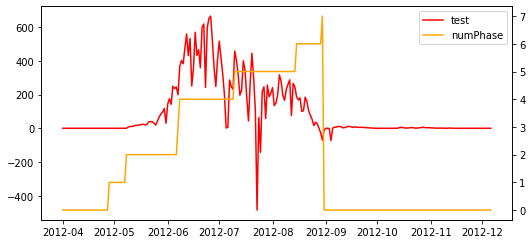

In [ ]:
data["test"] = data["deltaBiomasseTotale"]

variable1="test"
variable2="numPhase"

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

ax1 = plt.subplot()
l1, = ax1.plot(df_weather["Jour"], data[variable1][0,0,:], color='red')

ax2 = ax1.twinx()
l2, = ax2.plot(df_weather["Jour"], data[variable2][0,0,:], color='orange')

plt.legend([l1, l2], [variable1, variable2])
plt.xticks(rotation=45)
plt.show()

In [38]:
df = pd.DataFrame({"a":data["conv"].flatten(),"b":data["assimPot"].flatten()})
pd.set_option('display.max_rows', df.shape[0]+1)
print(df)

            a           b
0    0.000000    0.000000
1    0.000000    0.000000
2    0.000000    0.000000
3    0.000000    0.000000
4    0.000000    0.000000
5    0.000000    0.000000
6    0.000000    0.000000
7    0.000000    0.000000
8    0.000000    0.000000
9    0.000000    0.000000
10   0.000000    0.000000
11   0.000000    0.000000
12   0.000000    0.000000
13   0.000000    0.000000
14   0.000000    0.000000
15   0.000000    0.000000
16   0.000000    0.000000
17   0.000000    0.000000
18   0.000000    0.000000
19   0.000000    0.000000
20   0.000000    0.000000
21   0.000000    0.000000
22   0.000000    0.000000
23   0.000000    0.000000
24   0.000000    0.000000
25   0.000000    0.000000
26   0.000000    0.000000
27   0.000000    0.000000
28   0.000000    0.000000
29   0.000000    0.000000
30   0.000000    0.000000
31   0.000000    0.000000
32   0.000000    0.000000
33   0.000000    0.000000
34   0.000000    0.000000
35   0.000000    0.000000
36   0.000000    0.000000
37   5.80000

In [44]:
df_gt = pd.read_csv("../data/simu_AG3US20124.txt", sep="\t", decimal=",")
df_gt["Jour"] = df_gt.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)

df_gt

,Jour,NbJas,NumPhase,DegresDuJour,Lai,FTSW,Cstr,Eto,ETM,ETR,...,Conversion,StockTotal,BiomMc,StockMc,LitFeuilles,LitTiges,FeuillesUp,TigesUp,Hum,EToCO2
0,2012-04-01,-27,NaN,NaN,NaN,0.000000,0.000000,3.179907,3.179907,0.000000,...,0.0,170.000000,0,0,0,0,0.000000,0.000000,170.0000,3.179907
1,2012-04-02,-26,NaN,NaN,NaN,0.000000,0.000000,3.950088,3.950088,3.950088,...,0.0,193.409912,0,0,0,0,0.000000,0.000000,197.3600,3.950088
2,2012-04-03,-25,NaN,NaN,NaN,0.000000,0.000000,3.642551,3.642551,2.719009,...,0.0,190.690903,0,0,0,0,0.000000,0.000000,197.3600,3.642551
3,2012-04-04,-24,NaN,NaN,NaN,0.000000,0.000000,4.539865,4.539865,2.694119,...,0.0,187.996784,0,0,0,0,0.000000,0.000000,197.3600,4.539865
4,2012-04-05,-23,NaN,NaN,NaN,0.000000,0.000000,4.661987,4.661987,2.140356,...,0.0,185.856428,0,0,0,0,0.000000,0.000000,197.3600,4.661987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,2012-12-06,222,0.0,0.0,0.0,0.403482,0.684381,0.896016,0.488544,0.233363,...,0.0,131.586473,0,0,0,0,767.283559,9321.376757,140.7892,0.896016
250,2012-12-07,223,0.0,0.0,0.0,0.403482,0.684381,0.998676,0.544519,0.254088,...,0.0,131.332385,0,0,0,0,767.283559,9321.376757,140.7892,0.998676
251,2012-12-08,224,0.0,0.0,0.0,0.403482,0.684381,0.610870,0.333071,0.172241,...,0.0,132.460144,0,0,0,0,767.283559,9321.376757,140.7892,0.610870
252,2012-12-09,225,0.0,0.0,0.0,0.403482,0.684381,0.435127,0.237249,0.162192,...,0.0,135.597952,0,0,0,0,767.283559,9321.376757,140.7892,0.435127


In [54]:
def graph_comparison(var_gt, var_sim):


    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True

    ax1 = plt.subplot()
    l1, = ax1.plot(df_weather["Jour"], data[var_sim][0,0,:], color='red', label="sim")

    ax2 = ax1.twinx()
    l2, = ax2.plot(df_gt["Jour"], df_gt[var_gt], color='orange', label="sarrah")

    plt.legend([l1, l2], [var_sim+" (sim)", var_gt+" (sarrah)"])
    plt.xticks(rotation=45)
    plt.show()

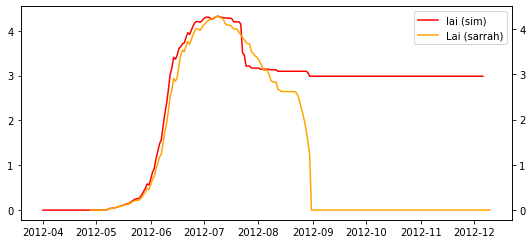

In [55]:
graph_comparison("Lai", "lai")

In [47]:
df_gt.columns

Index(['Jour', 'NbJas', 'NumPhase', 'DegresDuJour', 'Lai', 'FTSW', 'Cstr',
       'Eto', 'ETM', 'ETR', 'Sla', 'Assim', 'DayLength', 'Par', 'RgCalc',
       'VDPCalc', 'TMoyCalc', 'HMoyCalc', 'EauDispo', 'StockSurface',
       'StockRac', 'RURac', 'Kcp', 'Kce', 'EvapPot', 'Evap', 'TrPot', 'Tr',
       'Lr', 'Dr', 'SumDegresDay', 'BiomasseTotale', 'BiomasseAerienne',
       'BiomasseFeuilles', 'BiomasseTiges', 'BiomasseVegetative',
       'BiomasseRacinaire', 'Rdt', 'VitesseRacinaire', 'FESW', 'Kc', 'Ltr',
       'DRespMaint', 'DBiomTot', 'DRdtPot', 'Reallocation', 'RdtPot',
       'RayExtra', 'SumDDPhasePrec', 'SeuilTemp', 'TMinMoy', 'TMaxMoy',
       'FtswMoy', 'IrrigTotDay', 'Conversion', 'StockTotal', 'BiomMc',
       'StockMc', 'LitFeuilles', 'LitTiges', 'FeuillesUp', 'TigesUp', 'Hum',
       'EToCO2'],
      dtype='object')

In [97]:
def compute_earliest_diff(var_gt, var_sim, tol=0.0001):
    try:
        #tol = 0.0001
        df_gt_2 = df_gt
        df_gt_2 = df_gt_2.merge(pd.DataFrame({"Jour":df_weather["Jour"],var_sim:data[var_sim][0,0,:]}), left_on="Jour", right_on="Jour")
        df_gt_2["delta"] = df_gt_2[var_sim] - df_gt_2[var_gt]
        df_gt_2["signif"] = False
        df_gt_2["signif"] = df_gt_2.apply(lambda x: x["delta"]>tol, axis=1)
        earliest = df_gt_2.loc[df_gt_2["signif"]==True,"Jour"].values[0]
    except:
        earliest = np.nan
    return earliest

In [98]:
compute_earliest_diff("Par", "par")

nan

In [99]:
var_correspondance = {
    'DegresDuJour':"ddj",
    'Lai':"lai",
    'FTSW':"ftsw",
    'Cstr':"cstr",
    # 'Eto',
    # 'ETM',
    # 'ETR',
    'Sla':"sla",
    'Assim':"assim",
    # 'DayLength',
    # 'Par',
    # 'RgCalc',
    # 'VDPCalc',
    # 'TMoyCalc',
    # 'HMoyCalc',
    'EauDispo':'eauDispo',
    'StockSurface':"stRuSurf",
    'StockRac':"stRuRac",

    # 'RURac',
    'Kcp':'kcp',
    'Kce':"kce",
    'EvapPot':'evapPot',
    'Evap':"evap",
    'TrPot':"trPot",
    'Tr':"tr",
    'Lr':'lr',
    'Dr':'dr',
    #'SumDegresDay',
    'BiomasseTotale':"biomasseTotale",
    'BiomasseAerienne':'biomasseAerienne',
    'BiomasseFeuilles':"biomasseFeuille",
    'BiomasseTiges':"biomasseTige",
    'BiomasseVegetative':"biomasseVegetative",
    'BiomasseRacinaire':"biomasseRacinaire",
    'Rdt':"rdt",
    'VitesseRacinaire':"vRac",
    'FESW':"fesw",
    'Kc':"kc",
    'Ltr':'ltr',
    'DRespMaint':'dRespMaint',
    'DBiomTot':"dBiomTot",
    'DRdtPot':"dRdtPot", 
    'Reallocation':'realloc',
    'RdtPot':'rdtPot',
    # 'RayExtra',
    # 'SumDDPhasePrec',
    # 'SeuilTemp',
    # 'TMinMoy',
    # 'TMaxMoy',
    # 'FtswMoy',
    'IrrigTotDay':'irrigTotDay',
    'Conversion':'conv',
    'StockTotal':'stockTotal',
    'BiomMc':'biomMc',
    'StockMc':'stockMc',
    'LitFeuilles':"litFeuilles",
    'LitTiges':"litTiges",
    'FeuillesUp':"feuillesUp",
    'TigesUp':"tigesUp",
    'Hum':"hum",
    #'EToCO2',
}

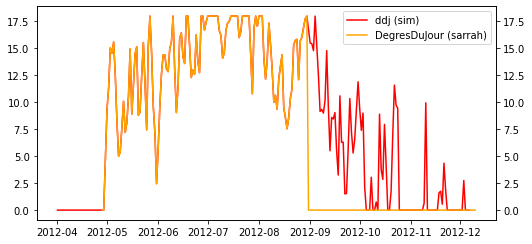

2012-08-31


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


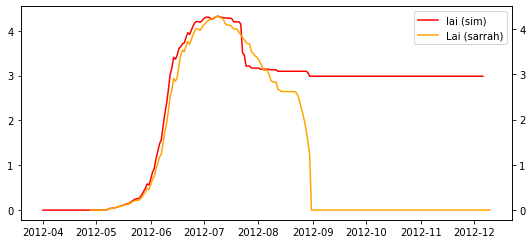

2012-05-09


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


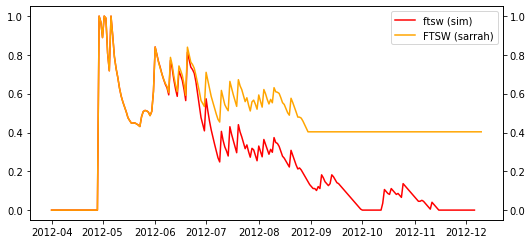

2012-05-24


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


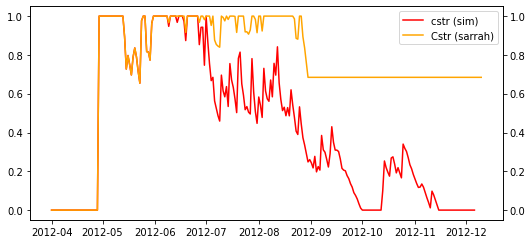

2012-05-21


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


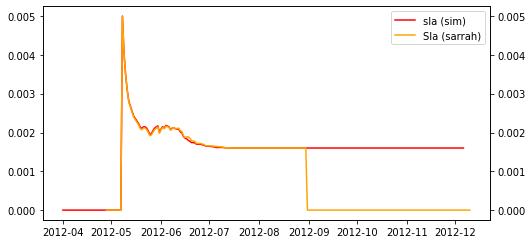

2012-08-31


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


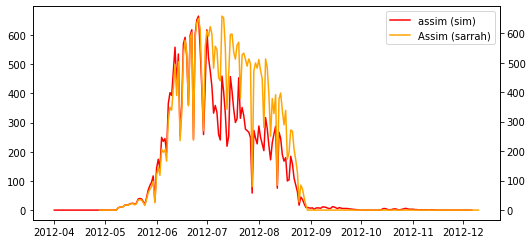

2012-05-10


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


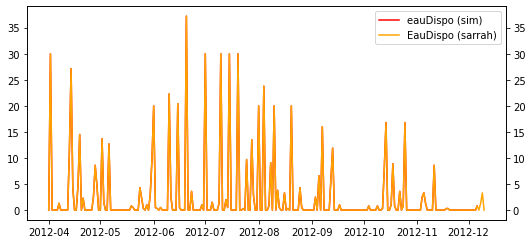

nan


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


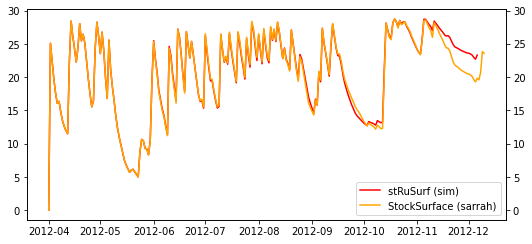

2012-05-12


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


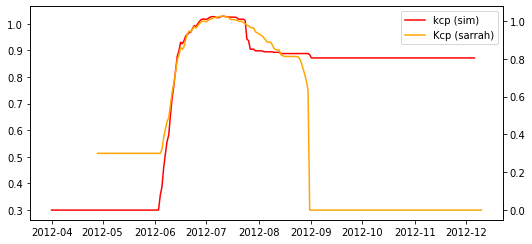

2012-06-03


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


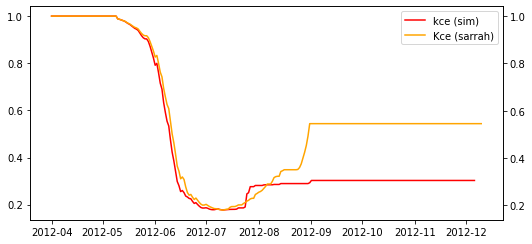

2012-07-25


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


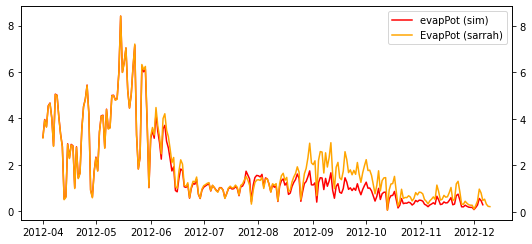

2012-07-25


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


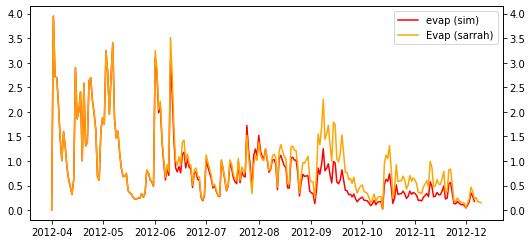

2012-07-25


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


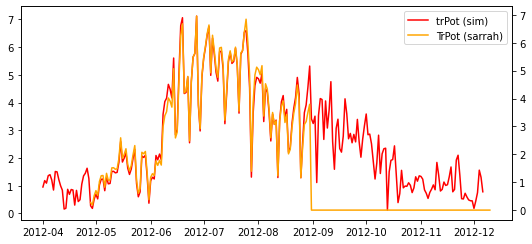

2012-06-03


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


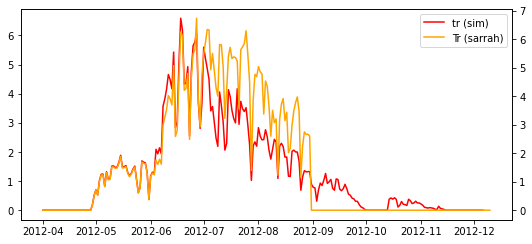

2012-05-18


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


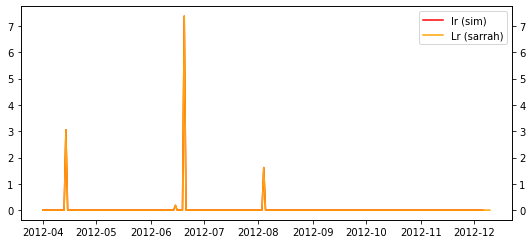

nan


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


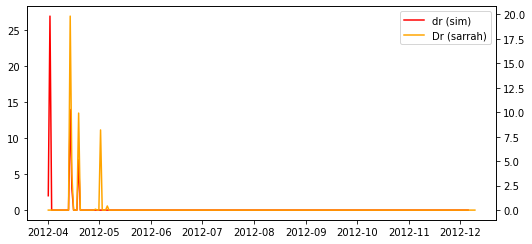

2012-04-01


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


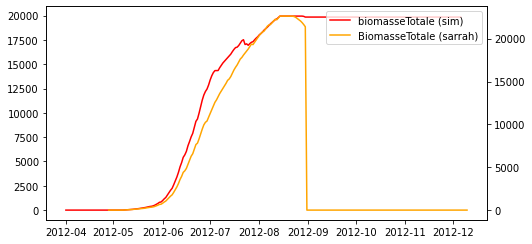

2012-05-09


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


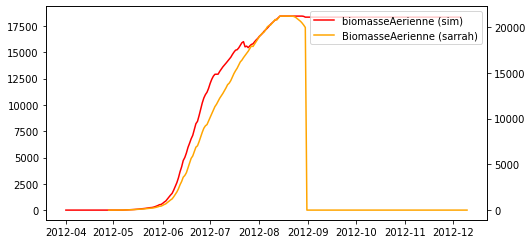

2012-05-09


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


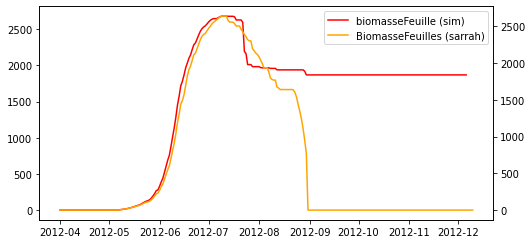

2012-05-09


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


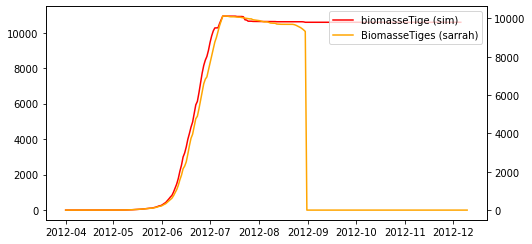

2012-05-09


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


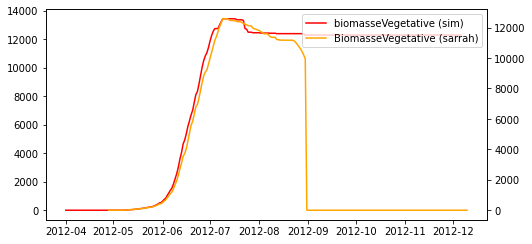

2012-05-09


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


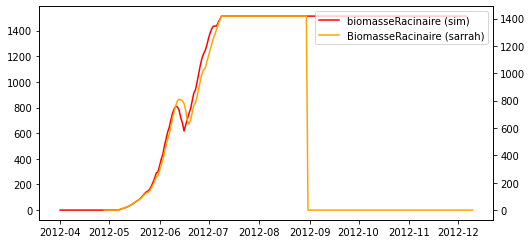

2012-05-09


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


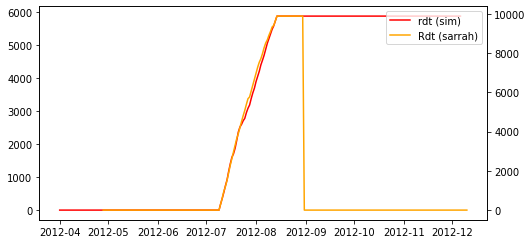

2012-08-31


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


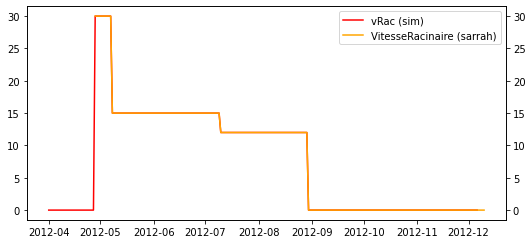

nan


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


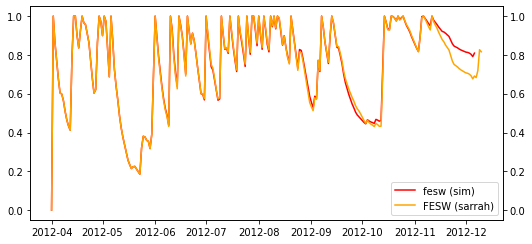

2012-05-20


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


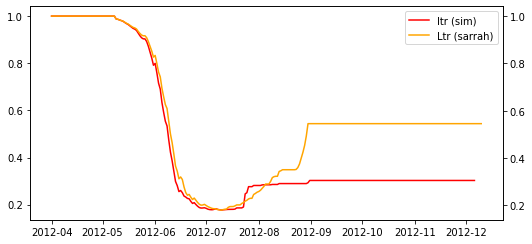

2012-07-24


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


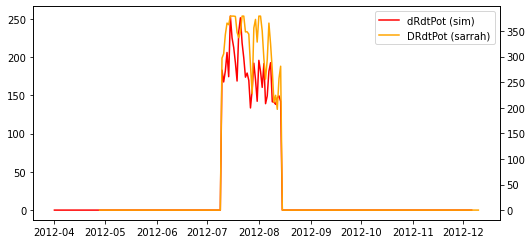

nan


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


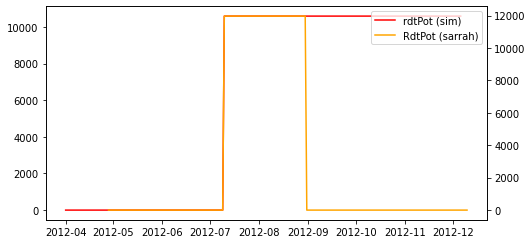

2012-08-31


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


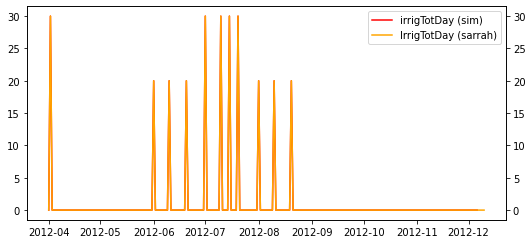

nan


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


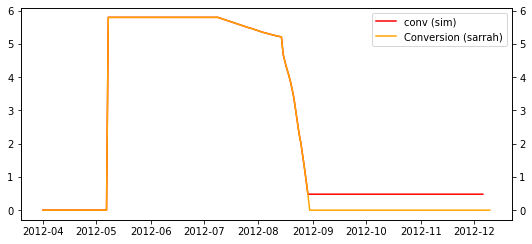

2012-08-30


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


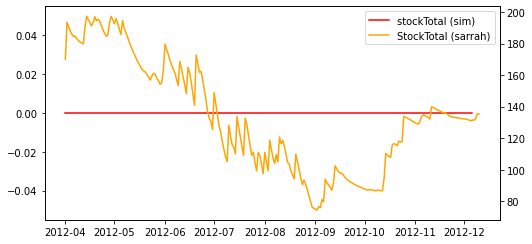

nan


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


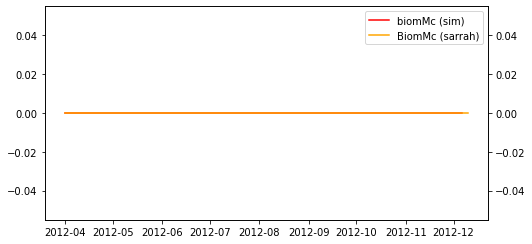

nan


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


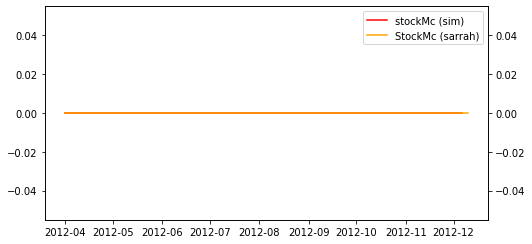

nan


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


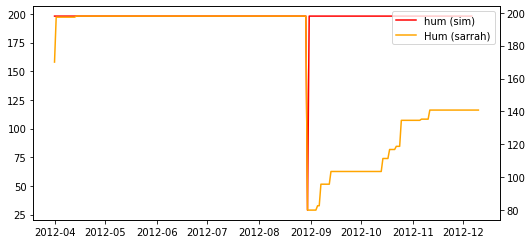

2012-04-01


/tmp/ipykernel_751/2325841416.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))


In [100]:
diff = pd.DataFrame()

for var in var_correspondance :
    try:
        # print(var,var_correspondance[var])
        graph_comparison(var, var_correspondance[var])
        date = compute_earliest_diff(var, var_correspondance[var])
        print(date)
        diff = diff.append(pd.DataFrame({"var":var,"earliest_diff":date}, index=[0]))
    except:
        pass

In [96]:
diff

,var,earliest_diff
0,DegresDuJour,2012-08-31
0,Lai,2012-05-09
0,FTSW,2012-05-24
0,Cstr,2012-05-21
0,Sla,2012-08-31
0,Assim,2012-05-10
0,EauDispo,no diff
0,StockSurface,2012-05-12
0,Kcp,2012-06-03
0,Kce,2012-07-25
